Using device: cpu
Inter-Electrode Dynamics Analysis
Neural ODE for OFC Electrode Connectivity

1. Loading data...
Loading subject 1...

  Data dimensions:
  - Neural data shape: (180, 57, 5)
  - Behavioral globals keys: ['exputil', 'gamble_ind', 'loss_ind', 'previous_exputil', 'previous_gamble_ind', 'previous_loss_ind', 'previous_regret', 'previous_risk', 'previous_rpe', 'previous_win_ind', 'previous_winprob', 'regret', 'risk', 'rpe', 'win_ind', 'winprob']
  - CSV columns: ['round', 'newround.time', 'choice.time', 'buttonpress.time', 'conf.time', 'reveal.time', 'choice.location', 'choice.class', 'outcome']
  - CSV length: 200
  - gamble_ind length: 180
  - risk length: 180
  - winprob length: 180
  - exputil length: 180

  Timeout handling:
  - Total CSV trials: 200
  - Timeouts found: 4
  - Valid trials in CSV: 196
  - Complex alignment: behav_df=180, valid_csv=196

  Successfully loaded:
  - 180 aligned trials
  - 5 electrodes
  - 57 time points per trial

   Data successfully loaded

Training: 100%|█████████████████████████████████| 29/29 [00:01<00:00, 17.76it/s]


Epoch 10/50
Train Loss: 0.746770, Val Loss: 0.750986
Learning Rate: 0.001000
--------------------------------------------------


Training: 100%|█████████████████████████████████| 29/29 [00:01<00:00, 17.66it/s]


Epoch 20/50
Train Loss: 0.610488, Val Loss: 0.632063
Learning Rate: 0.001000
--------------------------------------------------


Training: 100%|█████████████████████████████████| 29/29 [00:01<00:00, 18.04it/s]


Epoch 30/50
Train Loss: 0.554270, Val Loss: 0.565697
Learning Rate: 0.001000
--------------------------------------------------


Training: 100%|█████████████████████████████████| 29/29 [00:01<00:00, 18.12it/s]


Epoch 40/50
Train Loss: 0.537173, Val Loss: 0.536041
Learning Rate: 0.001000
--------------------------------------------------


Training: 100%|█████████████████████████████████| 29/29 [00:01<00:00, 18.18it/s]


Epoch 50/50
Train Loss: 0.524432, Val Loss: 0.526615
Learning Rate: 0.001000
--------------------------------------------------

6. Plotting training history...


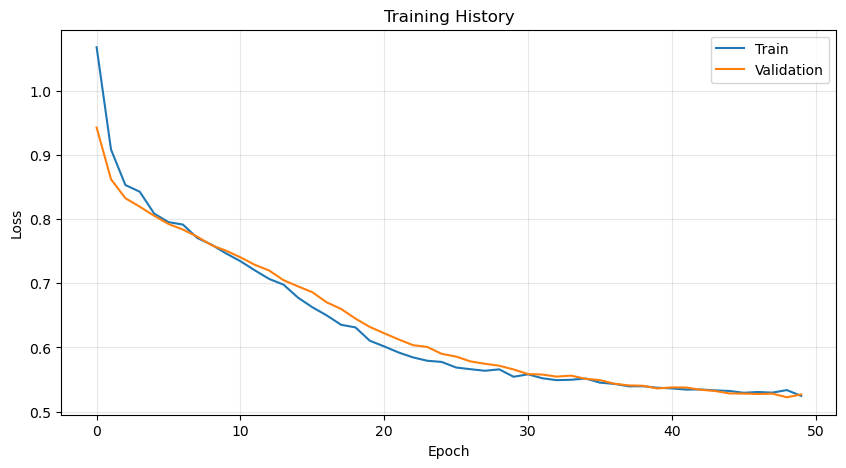


7. Analyzing electrode connectivity...


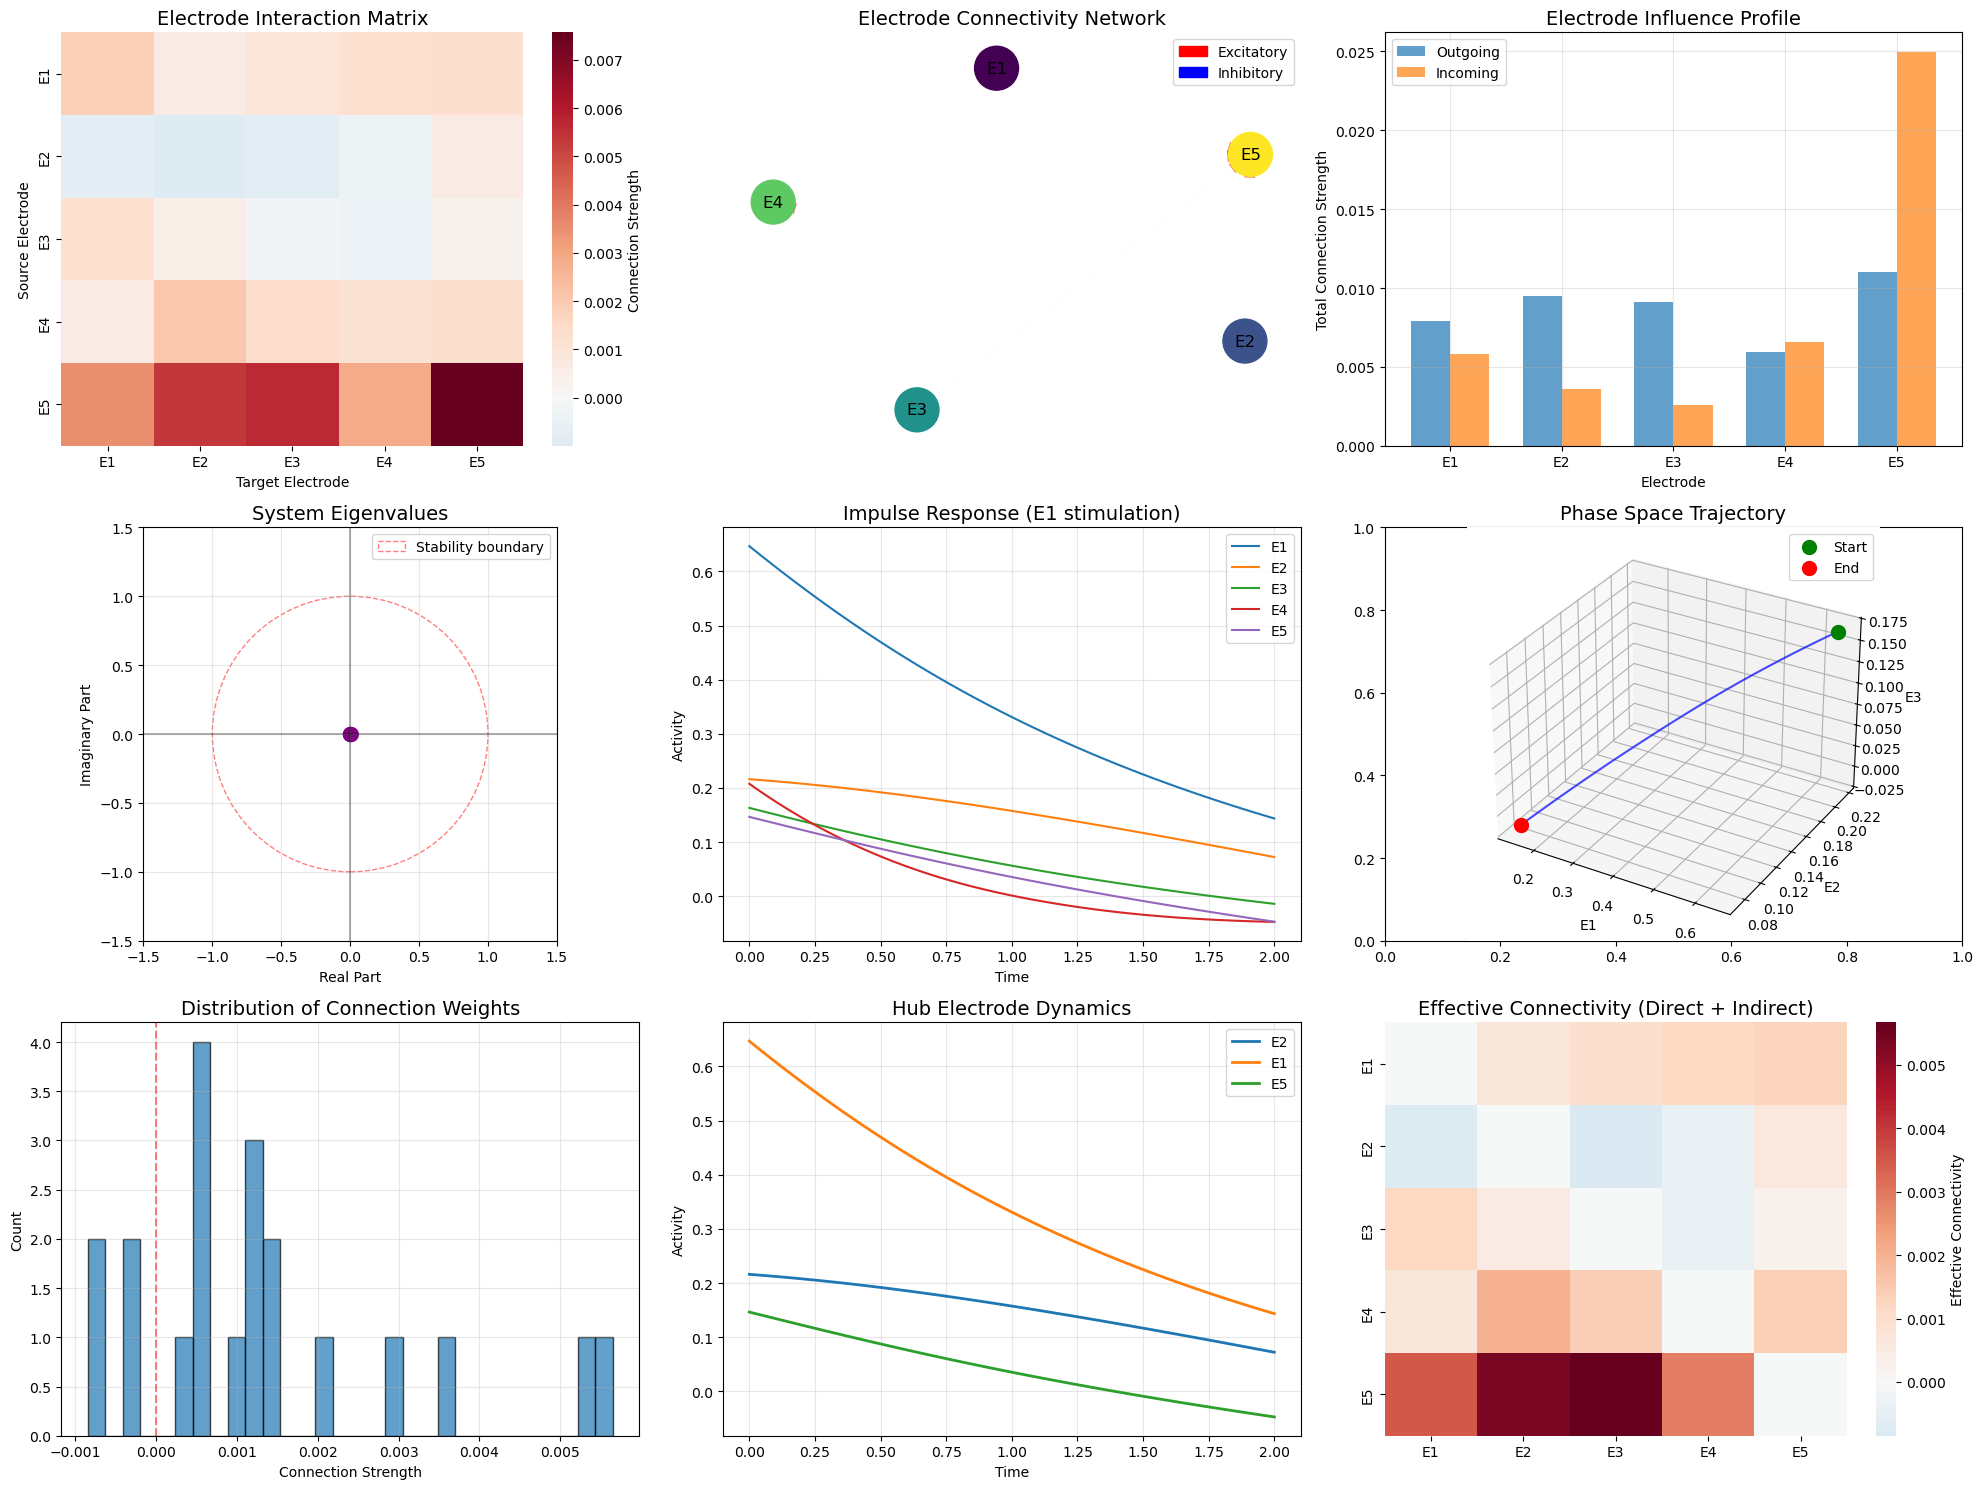


8. Testing prediction accuracy...


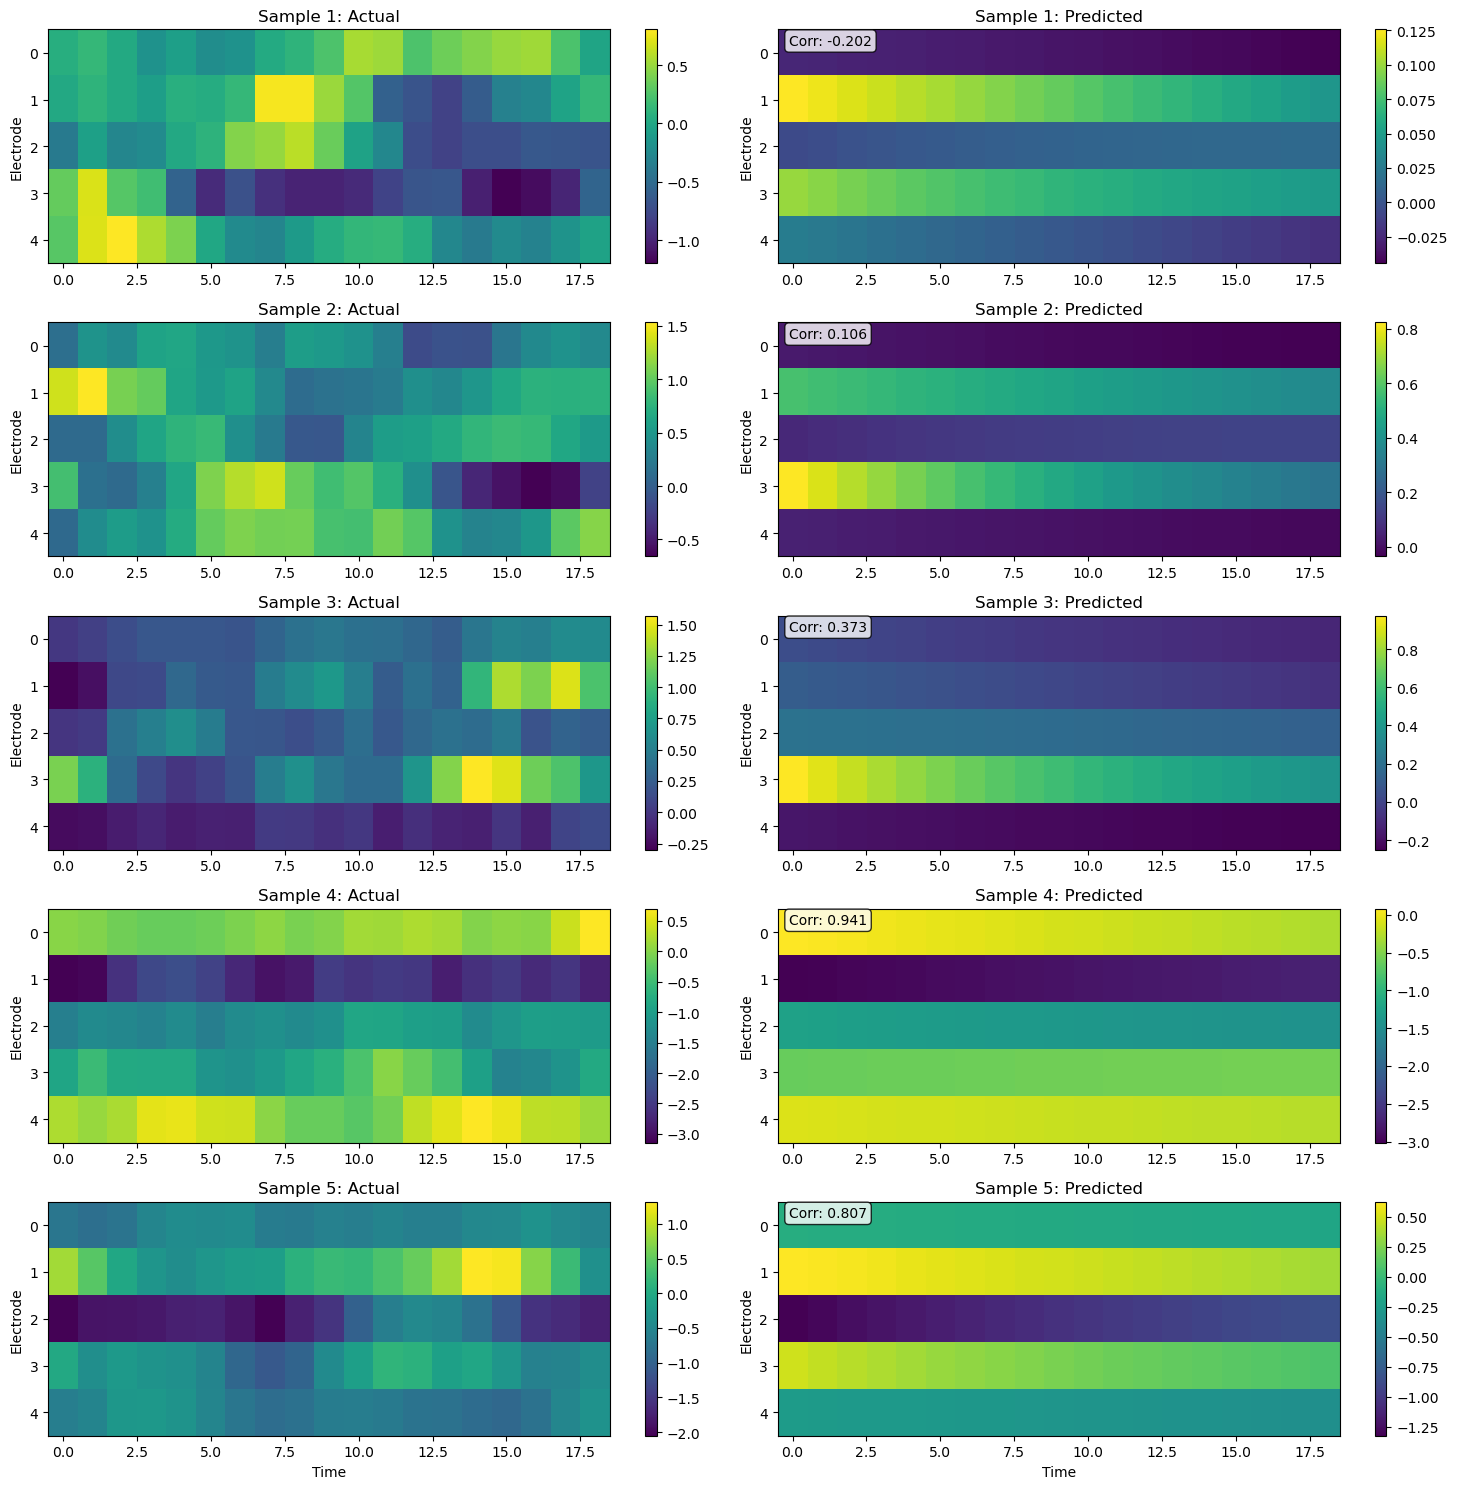


9. Analyzing temporal patterns...


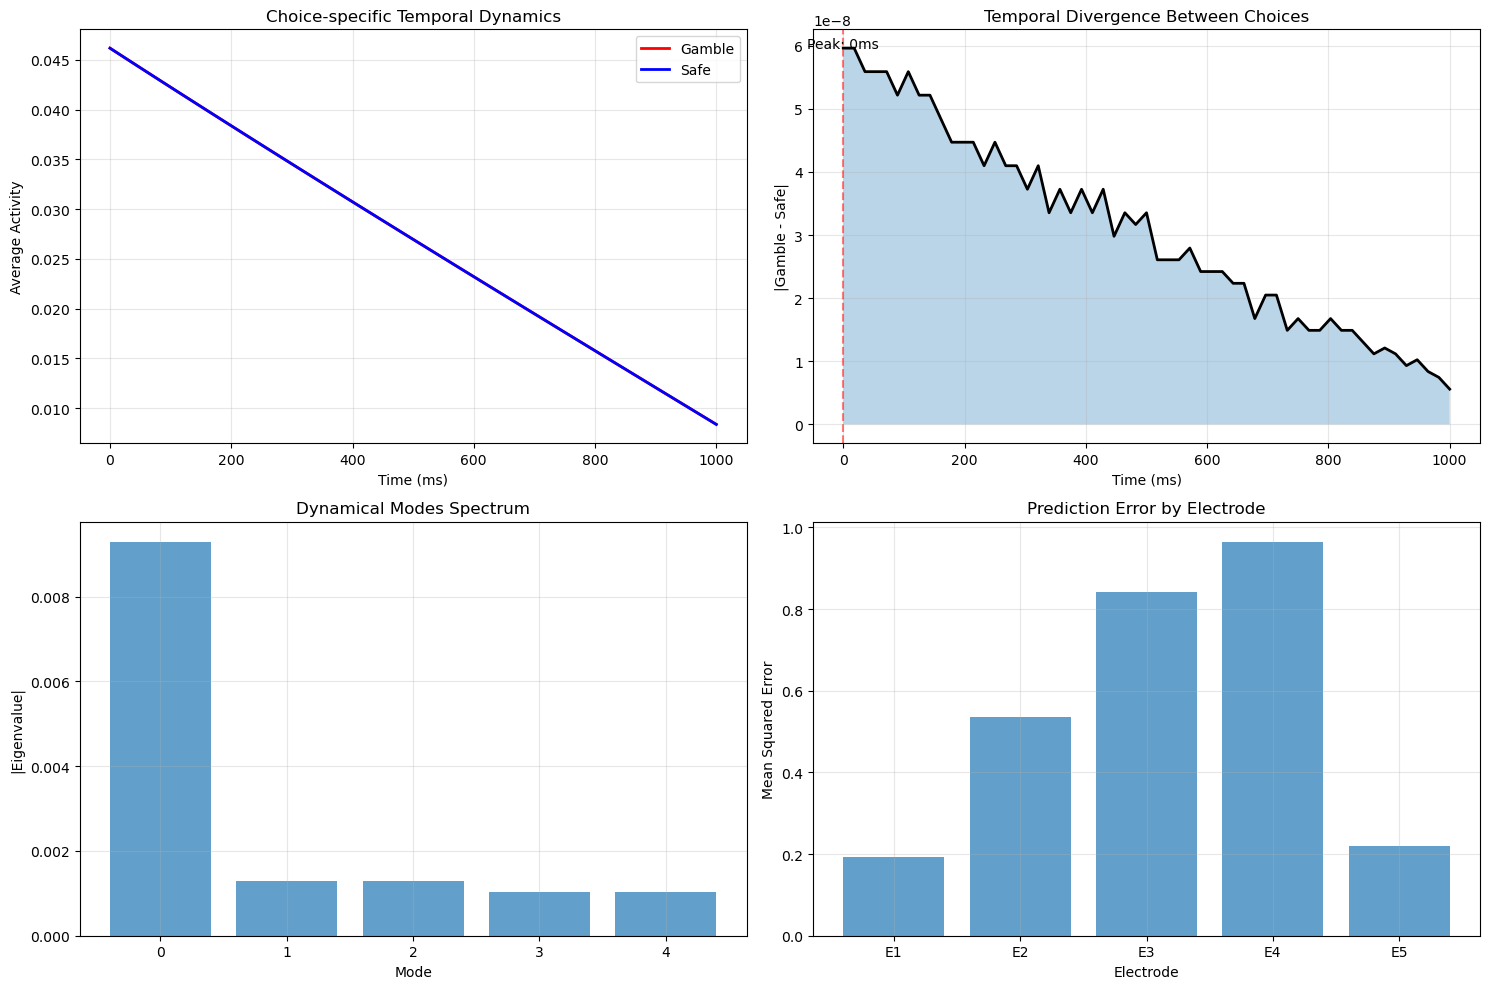


10. Summary Statistics:
----------------------------------------
Hub electrodes: ['E2', 'E1', 'E5']
Mean connection strength: 0.0017
Network sparsity: 100.00%
Max eigenvalue magnitude: 0.0093
System stability: Stable


In [8]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint, odeint_adjoint
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import networkx as nx
from pathlib import Path
import warnings
from tqdm import tqdm
from scipy import stats
from scipy.signal import hilbert, coherence
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ElectrodeDynamicsDataLoader:
    
    def __init__(self, data_path='./', ephys_folder='data_ephys', behav_folder='data_behav'):
        self.data_path = Path(data_path)
        self.ephys_path = self.data_path / ephys_folder
        self.behav_path = self.data_path / behav_folder
        self.scaler = StandardScaler()
        
    def load_subject_data(self, subject_id, verbose=True):
        print(f"Loading subject {subject_id}...")
        
        ephys_file = self.ephys_path / f's{subject_id:02d}_ofc_hg_events.mat'
        behav_globals_file = self.behav_path / f's{subject_id:02d}_behav_globals.mat'
        behav_csv_file = self.behav_path / f'gamble.data.s{subject_id:02d}.csv'
        
        for file_path, file_name in [(ephys_file, "Ephys"), 
                                     (behav_globals_file, "Behavioral globals"), 
                                     (behav_csv_file, "Behavioral CSV")]:
            if not file_path.exists():
                raise FileNotFoundError(f"{file_name} file not found: {file_path}")
        
        try:
            ephys_data = sio.loadmat(str(ephys_file))
            behav_globals = sio.loadmat(str(behav_globals_file))
            behav_csv = pd.read_csv(str(behav_csv_file))
        except Exception as e:
            raise RuntimeError(f"Error loading data files: {str(e)}")
        
        neural_game = ephys_data['game_window_events_hg']
        
        if verbose:
            print(f"\n  Data dimensions:")
            print(f"  - Neural data shape: {neural_game.shape}")
            print(f"  - Behavioral globals keys: {[k for k in behav_globals.keys() if not k.startswith('__')]}")
            print(f"  - CSV columns: {list(behav_csv.columns)}")
            print(f"  - CSV length: {len(behav_csv)}")
        
        required_fields = ['gamble_ind', 'risk', 'winprob', 'exputil']
        behav_arrays = {}
        
        for field in required_fields:
            if field not in behav_globals:
                raise KeyError(f"Required field '{field}' not found in behavioral globals")
            
            array = behav_globals[field].flatten()
            behav_arrays[field] = array
            
            if verbose:
                print(f"  - {field} length: {len(array)}")
        
        lengths = [len(arr) for arr in behav_arrays.values()]
        if len(set(lengths)) > 1:
            print(f"  WARNING: Behavioral arrays have different lengths: {dict(zip(required_fields, lengths))}")
            min_behav_length = min(lengths)
            for field in behav_arrays:
                behav_arrays[field] = behav_arrays[field][:min_behav_length]
        else:
            min_behav_length = lengths[0]
        
        behavioral_df = pd.DataFrame({
            'gamble_index': behav_arrays['gamble_ind'],
            'risk': behav_arrays['risk'],
            'win_probability': behav_arrays['winprob'],
            'chosen_value': behav_arrays['exputil'],
        })
        
        if 'choice.class' in behav_csv.columns:
            non_timeout_mask = behav_csv['choice.class'] != 'Timeout'
            non_timeout_indices = np.where(non_timeout_mask)[0]
            
            if verbose:
                n_timeouts = (~non_timeout_mask).sum()
                print(f"\n  Timeout handling:")
                print(f"  - Total CSV trials: {len(behav_csv)}")
                print(f"  - Timeouts found: {n_timeouts}")
                print(f"  - Valid trials in CSV: {len(non_timeout_indices)}")
            
            if len(behavioral_df) == len(behav_csv):
                behavioral_df = behavioral_df[non_timeout_mask].reset_index(drop=True)
                if verbose:
                    print(f"  - Using direct alignment (same length)")
            
            elif len(behavioral_df) == len(non_timeout_indices):
                if verbose:
                    print(f"  - Behavioral data appears pre-filtered")
            
            else:
                if verbose:
                    print(f"  - Complex alignment: behav_df={len(behavioral_df)}, valid_csv={len(non_timeout_indices)}")
                
                safe_length = min(len(behavioral_df), len(non_timeout_indices))
                behavioral_df = behavioral_df.iloc[:safe_length].reset_index(drop=True)
        
        n_neural_trials = neural_game.shape[0]
        n_behav_trials = len(behavioral_df)
        
        if n_neural_trials != n_behav_trials:
            if verbose:
                print(f"\n  Final alignment:")
                print(f"  - Neural trials: {n_neural_trials}")
                print(f"  - Behavioral trials: {n_behav_trials}")
            
            min_trials = min(n_neural_trials, n_behav_trials)
            neural_game = neural_game[:min_trials]
            behavioral_df = behavioral_df.iloc[:min_trials].reset_index(drop=True)
            
            if verbose:
                print(f"  - Using {min_trials} trials (minimum of both)")
        else:
            min_trials = n_neural_trials
        
        assert neural_game.shape[0] == len(behavioral_df), \
            f"Mismatch: neural has {neural_game.shape[0]} trials, behavioral has {len(behavioral_df)}"
        
        print(f"\n  Successfully loaded:")
        print(f"  - {min_trials} aligned trials")
        print(f"  - {neural_game.shape[2]} electrodes")
        print(f"  - {neural_game.shape[1]} time points per trial")
        
        return {
            'neural_data': neural_game,
            'behavioral': behavioral_df,
            'n_trials': min_trials,
            'n_electrodes': neural_game.shape[2],
            'n_timepoints': neural_game.shape[1]
        }
    
    def prepare_sequences(self, neural_data, sequence_length=20, stride=5):
        n_trials, n_time, n_electrodes = neural_data.shape
        sequences = []
        
        for trial in range(n_trials):
            for start in range(0, n_time - sequence_length + 1, stride):
                sequence = neural_data[trial, start:start+sequence_length, :]
                sequences.append(sequence)
        
        return np.array(sequences)

class ElectrodeDynamicsODE(nn.Module):
    
    def __init__(self, num_electrodes=10, hidden_dim=32, 
                 use_self_connections=True, sparsity_penalty=0.1):
        super().__init__()
        self.num_electrodes = num_electrodes
        self.use_self_connections = use_self_connections
        self.sparsity_penalty = sparsity_penalty
        
        self.W = nn.Parameter(torch.randn(num_electrodes, num_electrodes) * 0.1)
        
        self.bias = nn.Parameter(torch.zeros(num_electrodes))
        
        self.nonlinear_dynamics = nn.Sequential(
            nn.Linear(num_electrodes, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_electrodes)
        )
        
        self.time_modulation = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_electrodes),
            nn.Sigmoid()
        )
        
        self.input_gate = nn.Sequential(
            nn.Linear(num_electrodes, num_electrodes),
            nn.Sigmoid()
        )
        
    def get_interaction_matrix(self):
        W = self.W
        if not self.use_self_connections:
            W = W * (1 - torch.eye(self.num_electrodes, device=W.device))
        return W
    
    def forward(self, t, state):
        batch_size = state.shape[0]
        
        W = self.get_interaction_matrix()
        
        linear_term = torch.matmul(state, W.T) + self.bias
        
        nonlinear_term = self.nonlinear_dynamics(state)
        
        t_input = t.view(1, 1).expand(batch_size, 1)
        time_mod = self.time_modulation(t_input)
        
        gate = self.input_gate(state)
        
        dstate_dt = gate * linear_term + (1 - gate) * nonlinear_term
        dstate_dt = dstate_dt * time_mod
        
        dstate_dt = dstate_dt - 0.1 * state
        
        return dstate_dt

class InterElectrodeNeuralODE(nn.Module):
    
    def __init__(self, num_electrodes=10, hidden_dim=64, 
                 encoder_dim=32, decoder_dim=32,
                 solver='dopri5', rtol=1e-3, atol=1e-4):
        super().__init__()
        
        self.num_electrodes = num_electrodes
        
        self.encoder = nn.Sequential(
            nn.Linear(num_electrodes, encoder_dim),
            nn.ReLU(),
            nn.LayerNorm(encoder_dim),
            nn.Linear(encoder_dim, num_electrodes)
        )
        
        self.ode_func = ElectrodeDynamicsODE(
            num_electrodes=num_electrodes,
            hidden_dim=hidden_dim
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(num_electrodes, decoder_dim),
            nn.ReLU(),
            nn.LayerNorm(decoder_dim)
        )
        
        self.value_head = nn.Linear(decoder_dim, 1)
        self.choice_head = nn.Linear(decoder_dim, 2)
        
        self.solver = solver
        self.rtol = rtol
        self.atol = atol
        
    def forward(self, x0, t_span, return_full_trajectory=True):
        z0 = self.encoder(x0)
        
        if self.training:
            trajectory = odeint_adjoint(
                self.ode_func,
                z0,
                t_span,
                method=self.solver,
                rtol=self.rtol,
                atol=self.atol
            )
        else:
            trajectory = odeint(
                self.ode_func,
                z0,
                t_span,
                method=self.solver,
                rtol=self.rtol,
                atol=self.atol
            )
        
        final_state = trajectory[-1]
        decoded = self.decoder(final_state)
        
        value_pred = self.value_head(decoded)
        choice_pred = self.choice_head(decoded)
        
        outputs = {
            'value': value_pred,
            'choice': choice_pred,
            'final_state': final_state,
            'decoded_features': decoded
        }
        
        if return_full_trajectory:
            outputs['trajectory'] = trajectory
            
        return outputs

class ElectrodeSequenceDataset(Dataset):
    
    def __init__(self, sequences, transform=None):
        self.sequences = torch.FloatTensor(sequences)
        self.transform = transform
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        
        if self.transform:
            sequence = self.transform(sequence)
            
        return sequence[:-1], sequence[1:]

class ElectrodeDynamicsTrainer:
    
    def __init__(self, model, learning_rate=1e-3, weight_decay=1e-4):
        self.model = model
        self.device = device
        self.model.to(self.device)
        
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5,
            min_lr=1e-6
        )
        
        self.mse_loss = nn.MSELoss()
        
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        
        for batch_idx, (input_seq, target_seq) in enumerate(tqdm(train_loader, desc="Training")):
            input_seq = input_seq.to(self.device)
            target_seq = target_seq.to(self.device)
            
            batch_size, seq_len, num_electrodes = input_seq.shape
            
            x0 = input_seq[:, 0, :]
            
            t_span = torch.linspace(0, 1, seq_len + 1).to(self.device)
            
            outputs = self.model(x0, t_span, return_full_trajectory=True)
            predicted_trajectory = outputs['trajectory'][1:].permute(1, 0, 2)
            
            reconstruction_loss = self.mse_loss(predicted_trajectory, target_seq)
            
            W = self.model.ode_func.get_interaction_matrix()
            sparsity_loss = self.model.ode_func.sparsity_penalty * torch.abs(W).mean()
            
            loss = reconstruction_loss + sparsity_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            
        return total_loss / len(train_loader)
    
    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for input_seq, target_seq in val_loader:
                input_seq = input_seq.to(self.device)
                target_seq = target_seq.to(self.device)
                
                batch_size, seq_len, num_electrodes = input_seq.shape
                x0 = input_seq[:, 0, :]
                t_span = torch.linspace(0, 1, seq_len + 1).to(self.device)
                
                outputs = self.model(x0, t_span, return_full_trajectory=True)
                predicted_trajectory = outputs['trajectory'][1:].permute(1, 0, 2)
                
                loss = self.mse_loss(predicted_trajectory, target_seq)
                total_loss += loss.item()
                
        return total_loss / len(val_loader)
    
    def train(self, train_loader, val_loader, epochs=50):
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            train_loss = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            
            val_loss = self.evaluate(val_loader)
            val_losses.append(val_loss)
            
            self.scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_electrode_dynamics_model.pth')
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
                print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
                print("-" * 50)
        
        self.model.load_state_dict(torch.load('best_electrode_dynamics_model.pth'))
        
        return train_losses, val_losses

def analyze_electrode_connectivity(model, num_electrodes=10):
    
    model.eval()
    
    W = model.ode_func.get_interaction_matrix().detach().cpu().numpy()
    
    fig = plt.figure(figsize=(20, 15))
    
    ax1 = plt.subplot(3, 3, 1)
    sns.heatmap(W, cmap='RdBu_r', center=0, 
                xticklabels=[f'E{i+1}' for i in range(num_electrodes)],
                yticklabels=[f'E{i+1}' for i in range(num_electrodes)],
                cbar_kws={'label': 'Connection Strength'},
                ax=ax1)
    ax1.set_title('Electrode Interaction Matrix', fontsize=14)
    ax1.set_xlabel('Target Electrode')
    ax1.set_ylabel('Source Electrode')
    
    ax2 = plt.subplot(3, 3, 2)
    
    G = nx.DiGraph()
    for i in range(num_electrodes):
        G.add_node(i, label=f'E{i+1}')
    
    threshold = np.percentile(np.abs(W), 75)
    for i in range(num_electrodes):
        for j in range(num_electrodes):
            if i != j and np.abs(W[i, j]) > threshold:
                G.add_edge(j, i, weight=W[i, j], 
                          color='red' if W[i, j] > 0 else 'blue')
    
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    node_colors = plt.cm.viridis(np.linspace(0, 1, num_electrodes))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=1000, ax=ax2)
    
    edges = G.edges()
    colors = [G[u][v]['color'] for u, v in edges]
    weights = [abs(G[u][v]['weight']) * 3 for u, v in edges]
    
    nx.draw_networkx_edges(G, pos, edge_color=colors, 
                          width=weights, alpha=0.6, 
                          arrows=True, arrowsize=20, ax=ax2)
    
    labels = {i: f'E{i+1}' for i in range(num_electrodes)}
    nx.draw_networkx_labels(G, pos, labels, font_size=12, ax=ax2)
    
    ax2.set_title('Electrode Connectivity Network', fontsize=14)
    ax2.axis('off')
    
    red_patch = mpatches.Patch(color='red', label='Excitatory')
    blue_patch = mpatches.Patch(color='blue', label='Inhibitory')
    ax2.legend(handles=[red_patch, blue_patch], loc='upper right')
    
    ax3 = plt.subplot(3, 3, 3)
    
    in_degree = np.sum(np.abs(W), axis=1)
    out_degree = np.sum(np.abs(W), axis=0)
    
    x = np.arange(num_electrodes)
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, out_degree, width, label='Outgoing', alpha=0.7)
    bars2 = ax3.bar(x + width/2, in_degree, width, label='Incoming', alpha=0.7)
    
    ax3.set_xlabel('Electrode')
    ax3.set_ylabel('Total Connection Strength')
    ax3.set_title('Electrode Influence Profile', fontsize=14)
    ax3.set_xticks(x)
    ax3.set_xticklabels([f'E{i+1}' for i in range(num_electrodes)])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax4 = plt.subplot(3, 3, 4)
    
    eigenvalues = np.linalg.eigvals(W)
    
    ax4.scatter(eigenvalues.real, eigenvalues.imag, s=100, alpha=0.7, c='purple')
    ax4.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax4.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    circle = plt.Circle((0, 0), 1, fill=False, linestyle='--', 
                       color='red', alpha=0.5, label='Stability boundary')
    ax4.add_patch(circle)
    
    ax4.set_xlim(-1.5, 1.5)
    ax4.set_ylim(-1.5, 1.5)
    ax4.set_xlabel('Real Part')
    ax4.set_ylabel('Imaginary Part')
    ax4.set_title('System Eigenvalues', fontsize=14)
    ax4.set_aspect('equal')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    ax5 = plt.subplot(3, 3, 5)
    
    with torch.no_grad():
        x0 = torch.zeros(1, num_electrodes).to(device)
        x0[0, 0] = 1.0
        
        t_span = torch.linspace(0, 2, 100).to(device)
        
        outputs = model(x0, t_span, return_full_trajectory=True)
        trajectory = outputs['trajectory'].squeeze().cpu().numpy()
        
        time = t_span.cpu().numpy()
        for i in range(num_electrodes):
            ax5.plot(time, trajectory[:, i], label=f'E{i+1}' if i < 5 else None)
    
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Activity')
    ax5.set_title('Impulse Response (E1 stimulation)', fontsize=14)
    ax5.legend(loc='upper right')
    ax5.grid(True, alpha=0.3)
    
    ax6 = plt.subplot(3, 3, 6)
    
    if num_electrodes >= 3:
        ax6 = fig.add_subplot(3, 3, 6, projection='3d')
        ax6.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'b-', alpha=0.7)
        ax6.scatter(trajectory[0, 0], trajectory[0, 1], trajectory[0, 2], 
                   c='green', s=100, label='Start')
        ax6.scatter(trajectory[-1, 0], trajectory[-1, 1], trajectory[-1, 2], 
                   c='red', s=100, label='End')
        ax6.set_xlabel('E1')
        ax6.set_ylabel('E2')
        ax6.set_zlabel('E3')
        ax6.set_title('Phase Space Trajectory', fontsize=14)
        ax6.legend()
    
    ax7 = plt.subplot(3, 3, 7)
    
    W_flat = W[~np.eye(num_electrodes, dtype=bool)]
    
    ax7.hist(W_flat, bins=30, alpha=0.7, edgecolor='black')
    ax7.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax7.set_xlabel('Connection Strength')
    ax7.set_ylabel('Count')
    ax7.set_title('Distribution of Connection Weights', fontsize=14)
    ax7.grid(True, alpha=0.3)
    
    ax8 = plt.subplot(3, 3, 8)
    
    total_degree = in_degree + out_degree
    hub_indices = np.argsort(total_degree)[-3:]
    
    for idx in hub_indices:
        ax8.plot(time, trajectory[:, idx], linewidth=2, label=f'E{idx+1}')
    
    ax8.set_xlabel('Time')
    ax8.set_ylabel('Activity')
    ax8.set_title('Hub Electrode Dynamics', fontsize=14)
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    ax9 = plt.subplot(3, 3, 9)
    
    effective_conn = np.zeros((num_electrodes, num_electrodes))
    for i in range(num_electrodes):
        for j in range(num_electrodes):
            if i != j:
                effective_conn[i, j] = W[i, j] + 0.5 * np.sum(W[i, :] * W[:, j])
    
    sns.heatmap(effective_conn, cmap='RdBu_r', center=0,
                xticklabels=[f'E{i+1}' for i in range(num_electrodes)],
                yticklabels=[f'E{i+1}' for i in range(num_electrodes)],
                cbar_kws={'label': 'Effective Connectivity'},
                ax=ax9)
    ax9.set_title('Effective Connectivity (Direct + Indirect)', fontsize=14)
    
    plt.tight_layout()
    
    return fig, W

def test_electrode_prediction_accuracy(model, test_loader, num_samples=5):
    
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 3*num_samples))
    
    sample_idx = 0
    
    with torch.no_grad():
        for input_seq, target_seq in test_loader:
            if sample_idx >= num_samples:
                break
                
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)
            
            x0 = input_seq[0:1, 0, :]
            target = target_seq[0].cpu().numpy()
            
            seq_len = input_seq.shape[1]
            t_span = torch.linspace(0, 1, seq_len + 1).to(device)
            
            outputs = model(x0, t_span, return_full_trajectory=True)
            predicted = outputs['trajectory'][1:].squeeze().cpu().numpy()
            
            ax_actual = axes[sample_idx, 0]
            ax_pred = axes[sample_idx, 1]
            
            im1 = ax_actual.imshow(target.T, aspect='auto', cmap='viridis')
            ax_actual.set_ylabel('Electrode')
            ax_actual.set_title(f'Sample {sample_idx+1}: Actual')
            
            im2 = ax_pred.imshow(predicted.T, aspect='auto', cmap='viridis')
            ax_pred.set_ylabel('Electrode')
            ax_pred.set_title(f'Sample {sample_idx+1}: Predicted')
            
            plt.colorbar(im1, ax=ax_actual)
            plt.colorbar(im2, ax=ax_pred)
            
            corr = np.corrcoef(target.flatten(), predicted.flatten())[0, 1]
            ax_pred.text(0.02, 0.98, f'Corr: {corr:.3f}', 
                        transform=ax_pred.transAxes, 
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            sample_idx += 1
    
    axes[-1, 0].set_xlabel('Time')
    axes[-1, 1].set_xlabel('Time')
    
    plt.tight_layout()
    
    return fig

def analyze_temporal_patterns(model, neural_data, behavioral_df):
    
    model.eval()
    
    gamble_trials = behavioral_df['gamble_index'] == 1
    safe_trials = ~gamble_trials
    
    gamble_neural = neural_data[gamble_trials]
    safe_neural = neural_data[safe_trials]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    ax1 = axes[0, 0]
    
    with torch.no_grad():
        gamble_traj = []
        for trial in gamble_neural[:10]:
            x0 = torch.FloatTensor(trial[0:1]).to(device)
            t_span = torch.linspace(0, 1, len(trial)).to(device)
            outputs = model(x0, t_span, return_full_trajectory=True)
            gamble_traj.append(outputs['trajectory'].squeeze().cpu().numpy())
        
        safe_traj = []
        for trial in safe_neural[:10]:
            x0 = torch.FloatTensor(trial[0:1]).to(device)
            t_span = torch.linspace(0, 1, len(trial)).to(device)
            outputs = model(x0, t_span, return_full_trajectory=True)
            safe_traj.append(outputs['trajectory'].squeeze().cpu().numpy())
    
    gamble_avg = np.mean([np.mean(t, axis=1) for t in gamble_traj], axis=0)
    safe_avg = np.mean([np.mean(t, axis=1) for t in safe_traj], axis=0)
    
    time = np.linspace(0, 1000, len(gamble_avg))
    
    ax1.plot(time, gamble_avg, 'r-', label='Gamble', linewidth=2)
    ax1.plot(time, safe_avg, 'b-', label='Safe', linewidth=2)
    ax1.fill_between(time, gamble_avg, safe_avg, alpha=0.3)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Average Activity')
    ax1.set_title('Choice-specific Temporal Dynamics')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[0, 1]
    
    divergence = np.abs(gamble_avg - safe_avg)
    ax2.plot(time, divergence, 'k-', linewidth=2)
    ax2.fill_between(time, 0, divergence, alpha=0.3)
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('|Gamble - Safe|')
    ax2.set_title('Temporal Divergence Between Choices')
    ax2.grid(True, alpha=0.3)
    
    peak_idx = np.argmax(divergence)
    ax2.axvline(x=time[peak_idx], color='red', linestyle='--', alpha=0.5)
    ax2.text(time[peak_idx], divergence[peak_idx], 
            f'Peak: {time[peak_idx]:.0f}ms', 
            horizontalalignment='center')
    
    ax3 = axes[1, 0]
    
    W = model.ode_func.get_interaction_matrix().detach().cpu().numpy()
    
    eigenvalues, eigenvectors = np.linalg.eig(W)
    
    idx = np.argsort(np.abs(eigenvalues))[::-1]
    eigenvalues = eigenvalues[idx]
    
    ax3.bar(range(len(eigenvalues)), np.abs(eigenvalues), alpha=0.7)
    ax3.set_xlabel('Mode')
    ax3.set_ylabel('|Eigenvalue|')
    ax3.set_title('Dynamical Modes Spectrum')
    ax3.grid(True, alpha=0.3)
    
    ax4 = axes[1, 1]
    
    electrode_errors = []
    
    with torch.no_grad():
        for trial in neural_data[:20]:
            x0 = torch.FloatTensor(trial[0:1]).to(device)
            t_span = torch.linspace(0, 1, len(trial)).to(device)
            outputs = model(x0, t_span, return_full_trajectory=True)
            predicted = outputs['trajectory'].squeeze().cpu().numpy()
            
            error = np.mean((predicted - trial)**2, axis=0)
            electrode_errors.append(error)
    
    mean_errors = np.mean(electrode_errors, axis=0)
    
    ax4.bar(range(len(mean_errors)), mean_errors, alpha=0.7)
    ax4.set_xlabel('Electrode')
    ax4.set_ylabel('Mean Squared Error')
    ax4.set_title('Prediction Error by Electrode')
    ax4.set_xticks(range(len(mean_errors)))
    ax4.set_xticklabels([f'E{i+1}' for i in range(len(mean_errors))])
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig

def check_data_alignment(subject_id, data_path='./'):
    ephys_path = Path(data_path) / 'data_ephys'
    behav_path = Path(data_path) / 'data_behav'
    
    print(f"\nChecking data alignment for subject {subject_id}...")
    
    try:
        ephys = sio.loadmat(ephys_path / f's{subject_id:02d}_ofc_hg_events.mat')
        globals = sio.loadmat(behav_path / f's{subject_id:02d}_behav_globals.mat')
        csv = pd.read_csv(behav_path / f'gamble.data.s{subject_id:02d}.csv')
        
        print(f"\nSubject {subject_id} data dimensions:")
        print(f"- Neural: {ephys['game_window_events_hg'].shape}")
        print(f"- Globals 'gamble_ind': {globals['gamble_ind'].shape}")
        print(f"- CSV rows: {len(csv)}")
        
        if 'choice.class' in csv.columns:
            print(f"- CSV non-timeouts: {(csv['choice.class'] != 'Timeout').sum()}")
            print(f"- CSV timeouts: {(csv['choice.class'] == 'Timeout').sum()}")
        
        print("\nBehavioral globals available fields:")
        for key in globals.keys():
            if not key.startswith('__'):
                print(f"  - {key}: shape {globals[key].shape}")
                
    except Exception as e:
        print(f"Error checking data: {str(e)}")

def main():
    
    print("="*60)
    print("Inter-Electrode Dynamics Analysis")
    print("Neural ODE for OFC Electrode Connectivity")
    print("="*60)
    
    print("\n1. Loading data...")
    data_loader = ElectrodeDynamicsDataLoader()
    
    try:
        subject_data = data_loader.load_subject_data(1, verbose=True)
    except Exception as e:
        print(f"\nError loading data: {str(e)}")
        print("\nTrying diagnostic check...")
        check_data_alignment(1)
        raise
    
    neural_data = subject_data['neural_data']
    behavioral_df = subject_data['behavioral']
    
    print(f"\n   Data successfully loaded:")
    print(f"   Data shape: {neural_data.shape}")
    print(f"   Trials: {subject_data['n_trials']}")
    print(f"   Electrodes: {subject_data['n_electrodes']}")
    print(f"   Time points: {subject_data['n_timepoints']}")
    
    print("\n2. Preparing sequences for training...")
    sequences = data_loader.prepare_sequences(neural_data, sequence_length=20, stride=5)
    print(f"   Total sequences: {len(sequences)}")
    
    scaler = StandardScaler()
    sequences_flat = sequences.reshape(-1, sequences.shape[-1])
    sequences_flat = scaler.fit_transform(sequences_flat)
    sequences = sequences_flat.reshape(sequences.shape)
    
    print("\n3. Creating train/validation/test sets...")
    train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)
    train_sequences, val_sequences = train_test_split(train_sequences, test_size=0.2, random_state=42)
    
    train_dataset = ElectrodeSequenceDataset(train_sequences)
    val_dataset = ElectrodeSequenceDataset(val_sequences)
    test_dataset = ElectrodeSequenceDataset(test_sequences)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"   Train: {len(train_dataset)} sequences")
    print(f"   Val: {len(val_dataset)} sequences")
    print(f"   Test: {len(test_dataset)} sequences")
    
    print("\n4. Creating Neural ODE model...")
    model = InterElectrodeNeuralODE(
        num_electrodes=subject_data['n_electrodes'],
        hidden_dim=64,
        encoder_dim=32,
        decoder_dim=32,
        solver='dopri5'
    )
    
    print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    print("\n5. Training model...")
    trainer = ElectrodeDynamicsTrainer(model, learning_rate=1e-3)
    
    train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=50)
    
    print("\n6. Plotting training history...")
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('training_history_electrodes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n7. Analyzing electrode connectivity...")
    connectivity_fig, W = analyze_electrode_connectivity(model, subject_data['n_electrodes'])
    connectivity_fig.savefig('electrode_connectivity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n8. Testing prediction accuracy...")
    prediction_fig = test_electrode_prediction_accuracy(model, test_loader, num_samples=5)
    prediction_fig.savefig('electrode_prediction_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n9. Analyzing temporal patterns...")
    
    neural_normalized = neural_data.copy()
    for i in range(neural_normalized.shape[0]):
        neural_normalized[i] = scaler.transform(neural_normalized[i])
    
    temporal_fig = analyze_temporal_patterns(model, neural_normalized, behavioral_df)
    temporal_fig.savefig('temporal_patterns_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n10. Summary Statistics:")
    print("-" * 40)
    
    total_influence = np.sum(np.abs(W), axis=0) + np.sum(np.abs(W), axis=1)
    hub_electrodes = np.argsort(total_influence)[-3:]
    print(f"Hub electrodes: {[f'E{i+1}' for i in hub_electrodes]}")
    
    print(f"Mean connection strength: {np.mean(np.abs(W)):.4f}")
    print(f"Network sparsity: {np.mean(np.abs(W) < 0.1):.2%}")
    
    eigenvalues = np.linalg.eigvals(W)
    max_eigenvalue = np.max(np.abs(eigenvalues))
    print(f"Max eigenvalue magnitude: {max_eigenvalue:.4f}")
    print(f"System stability: {'Stable' if max_eigenvalue < 1 else 'Unstable'}")
    
    return model, interaction_matrix

if __name__ == "__main__":
    model, interaction_matrix = main()

Using device: cpu
Simplified Neural ODE for 5-Electrode System

1. Loading data...
Loading subject 1...

  Successfully loaded:
  - 180 aligned trials
  - 5 electrodes
  - 57 time points per trial

2. Preparing sequences...
   Total sequences: 900

3. Normalizing data...

4. Creating train/validation/test sets...
   Train: 576 sequences
   Val: 144 sequences
   Test: 180 sequences

5. Creating simplified Neural ODE model...
   Model parameters: 58
   (Compare to original: ~15,000 parameters)

6. Training model...


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 230.50it/s]



Epoch 10/100
Train Loss: 0.428890 (MSE: 0.428374, Sparse: 0.001881, Div: -0.001364)
Val Loss: 0.553227
LR: 0.010000


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 218.59it/s]



Epoch 20/100
Train Loss: 0.425539 (MSE: 0.425122, Sparse: 0.001668, Div: -0.001251)
Val Loss: 0.550926
LR: 0.010000


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 232.99it/s]



Epoch 30/100
Train Loss: 0.424776 (MSE: 0.424370, Sparse: 0.001646, Div: -0.001240)
Val Loss: 0.549078
LR: 0.010000


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 229.97it/s]



Epoch 40/100
Train Loss: 0.423504 (MSE: 0.423105, Sparse: 0.001653, Div: -0.001253)
Val Loss: 0.548956
LR: 0.005000


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 219.84it/s]



Epoch 50/100
Train Loss: 0.423168 (MSE: 0.422785, Sparse: 0.001638, Div: -0.001255)
Val Loss: 0.548526
LR: 0.002500


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 227.76it/s]



Epoch 60/100
Train Loss: 0.422813 (MSE: 0.422430, Sparse: 0.001640, Div: -0.001257)
Val Loss: 0.548583
LR: 0.001250


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 230.61it/s]



Epoch 70/100
Train Loss: 0.422634 (MSE: 0.422249, Sparse: 0.001640, Div: -0.001256)
Val Loss: 0.548535
LR: 0.000625


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 231.84it/s]



Epoch 80/100
Train Loss: 0.422502 (MSE: 0.422117, Sparse: 0.001641, Div: -0.001255)
Val Loss: 0.548356
LR: 0.000313


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 230.42it/s]



Epoch 90/100
Train Loss: 0.422445 (MSE: 0.422057, Sparse: 0.001644, Div: -0.001256)
Val Loss: 0.548305
LR: 0.000156


Training: 100%|████████████████████████████████| 36/36 [00:00<00:00, 232.20it/s]



Epoch 100/100
Train Loss: 0.422422 (MSE: 0.422035, Sparse: 0.001644, Div: -0.001256)
Val Loss: 0.548301
LR: 0.000078

7. Plotting training history...


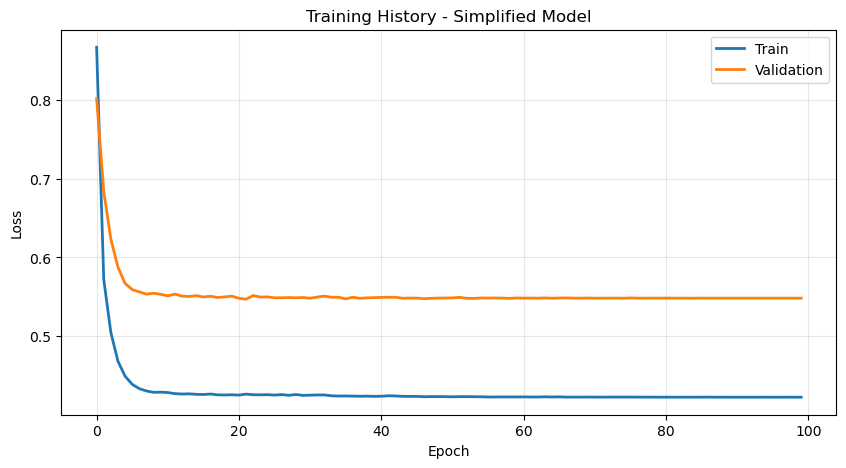


8. Analyzing electrode connectivity...


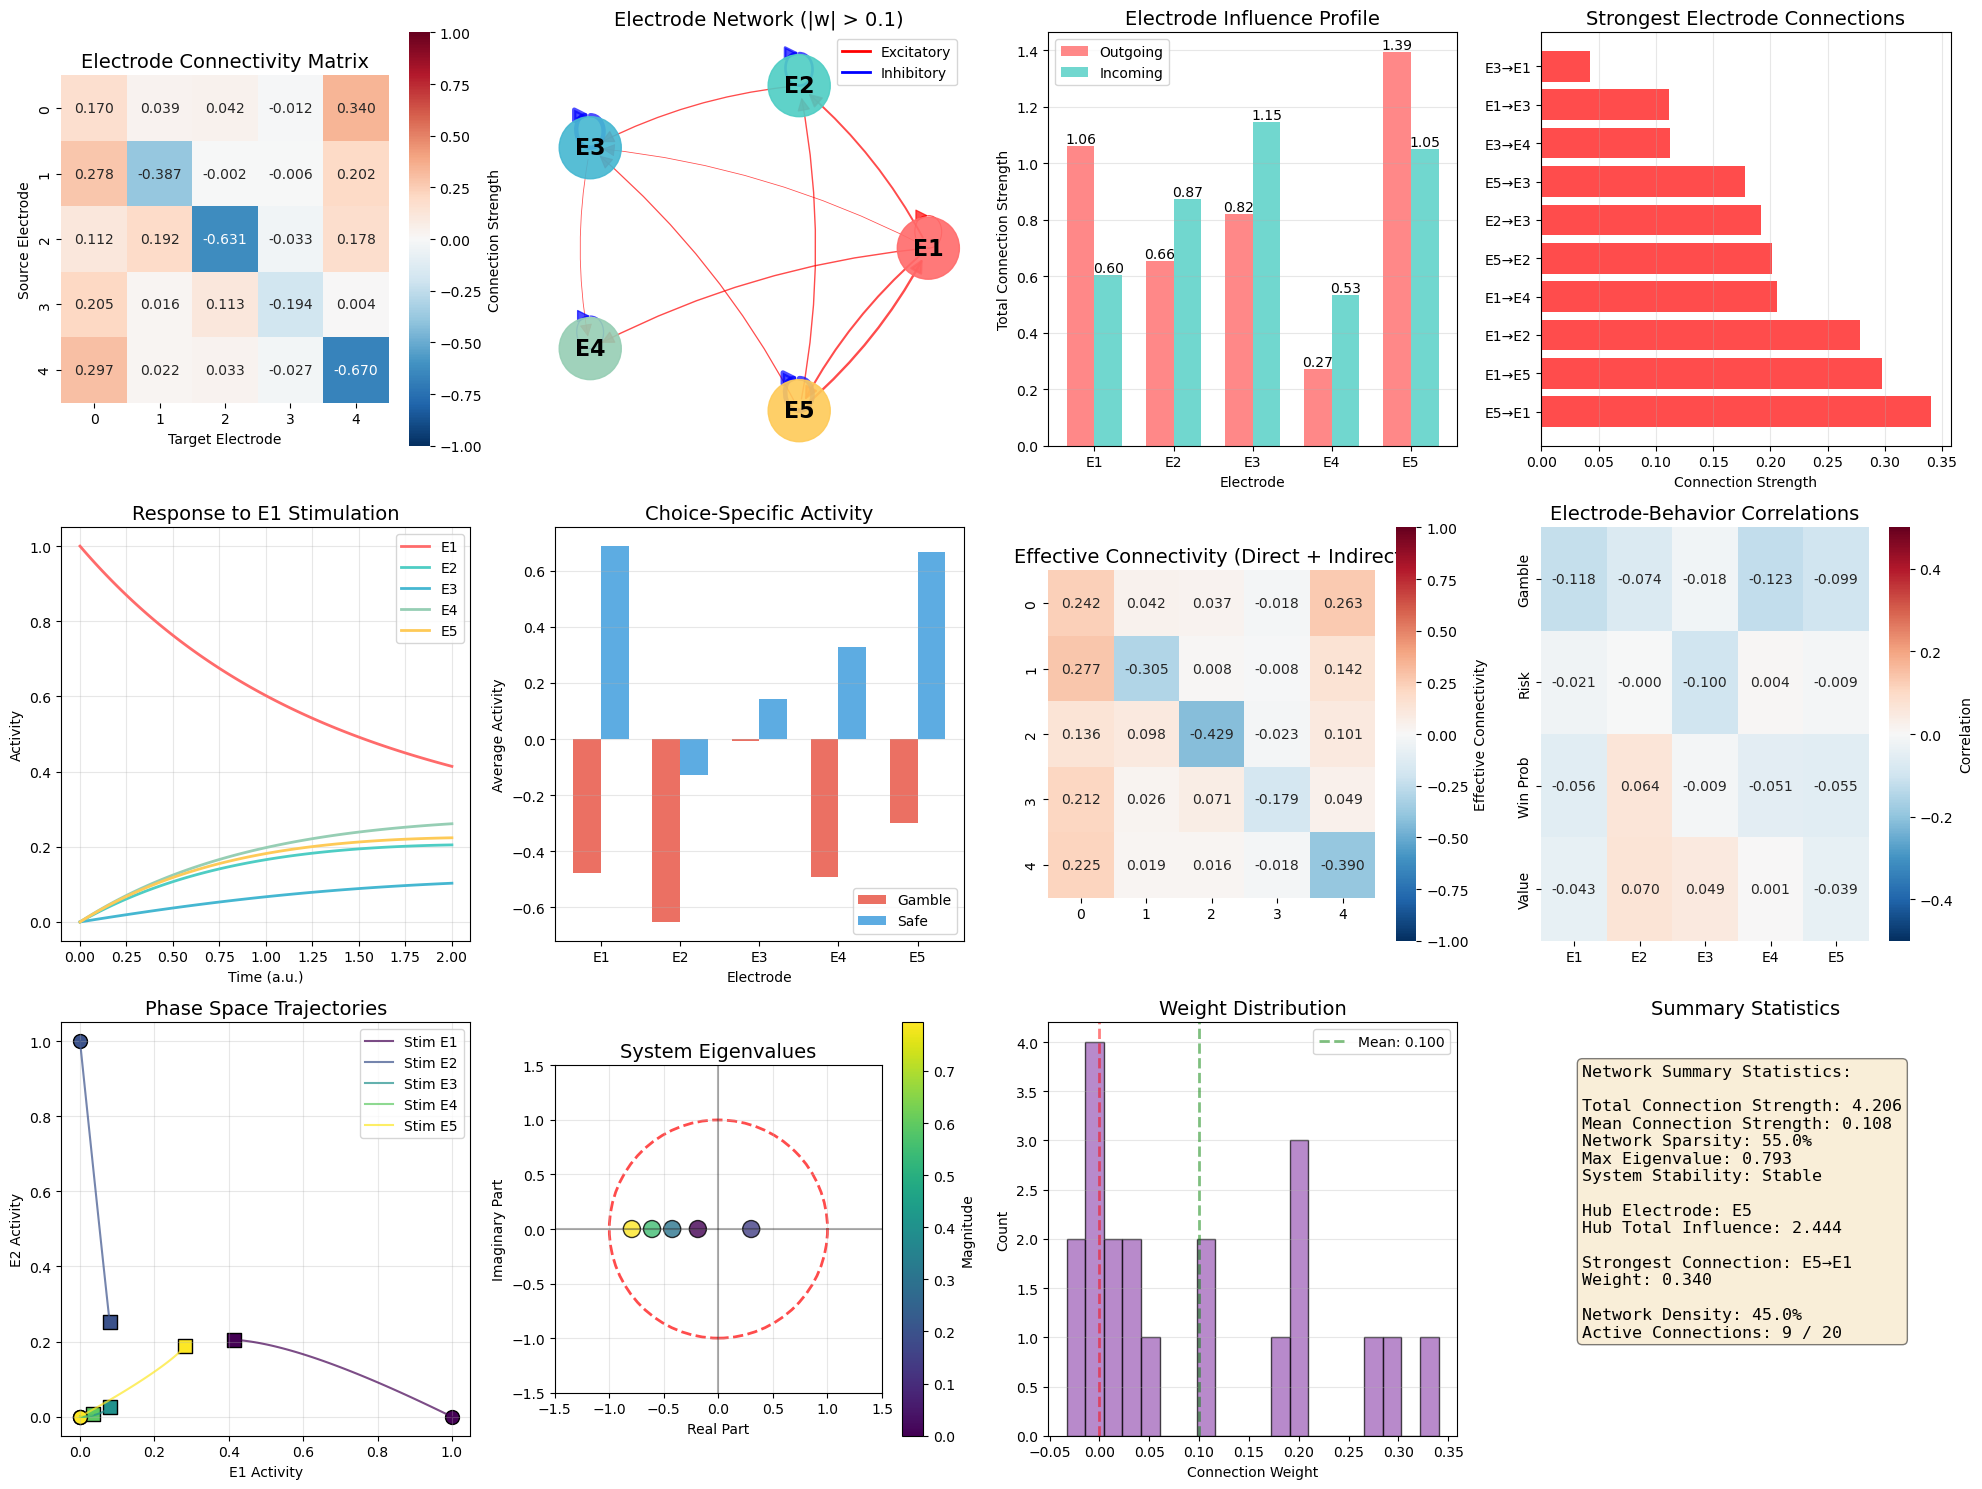


9. Testing prediction accuracy...


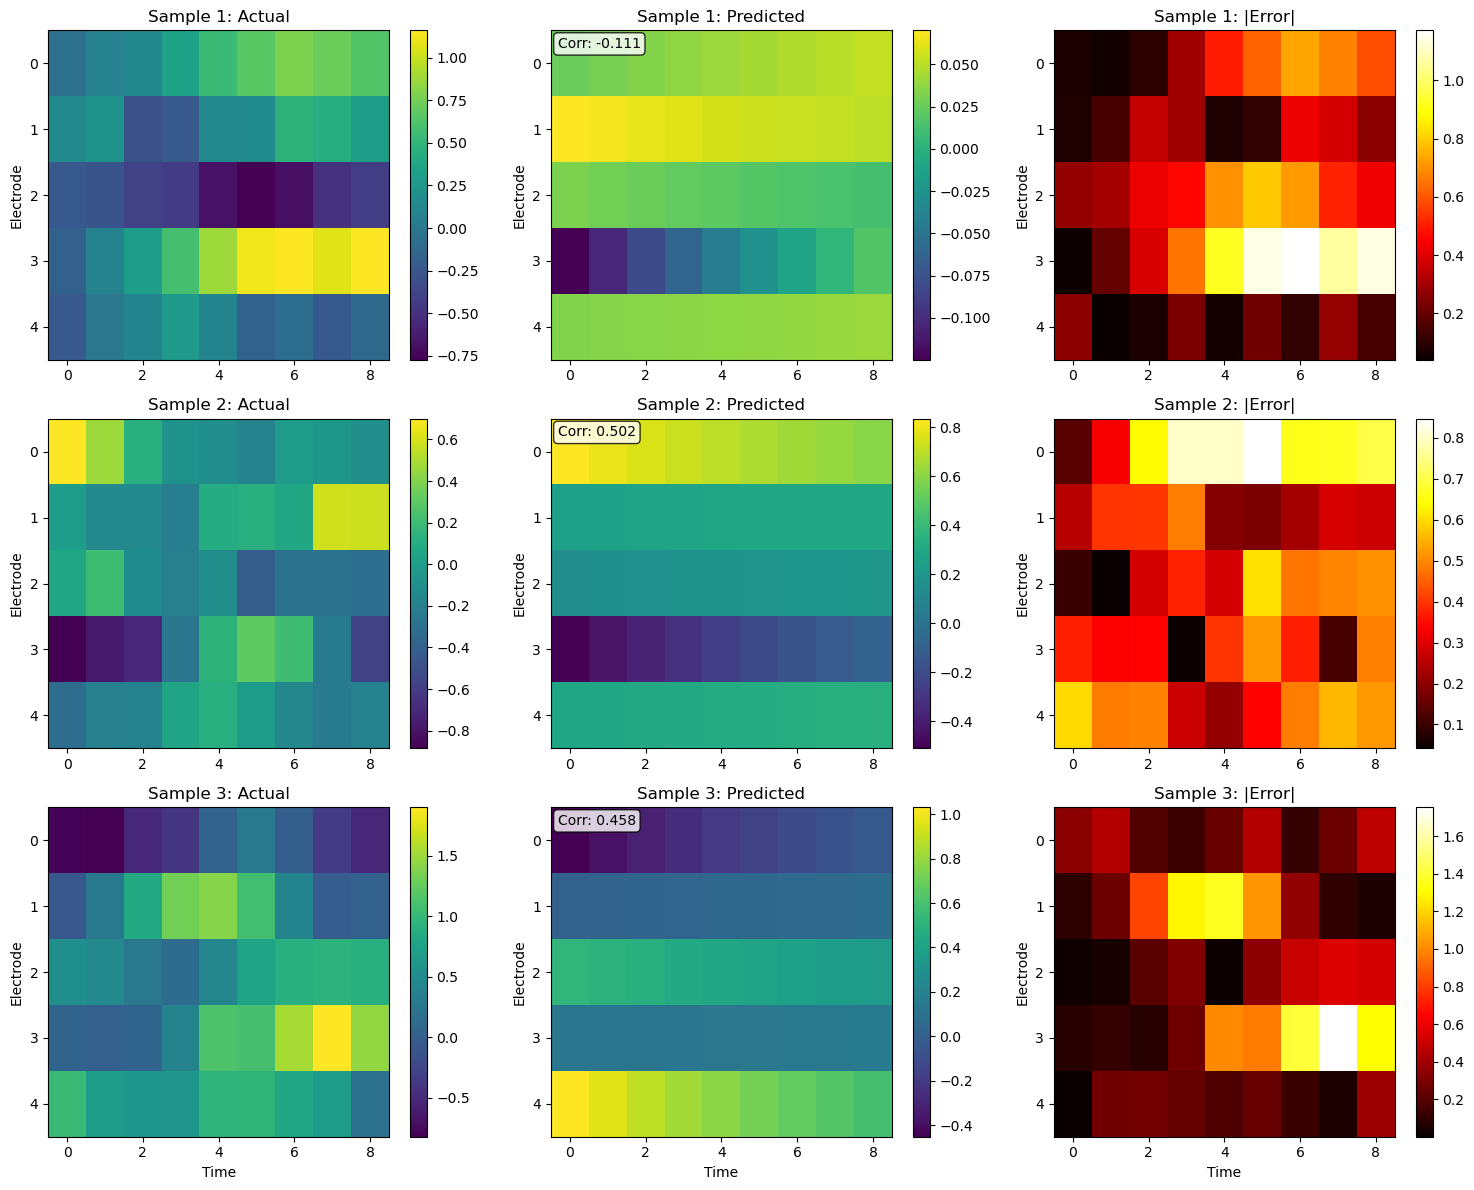


10. Final Network Summary:
--------------------------------------------------
Mean connection strength: 0.1077
Max connection strength: 0.3403
Network sparsity (|w| < 0.1): 55.0%
Active connections: 9 / 20
Max eigenvalue: 0.7932
System stability: Stable

Strong connections (|w| > 0.1):
  E5 → E1: 0.340
  E1 → E2: 0.278
  E5 → E2: 0.202
  E1 → E3: 0.112
  E2 → E3: 0.192
  E5 → E3: 0.178
  E1 → E4: 0.205
  E3 → E4: 0.113
  E1 → E5: 0.297


In [6]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import networkx as nx
from pathlib import Path
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class ElectrodeDynamicsDataLoader:
    """Data loader optimized for small electrode arrays"""
    
    def __init__(self, data_path='./', ephys_folder='data_ephys', behav_folder='data_behav'):
        self.data_path = Path(data_path)
        self.ephys_path = self.data_path / ephys_folder
        self.behav_path = self.data_path / behav_folder
        self.scaler = StandardScaler()
        
    def load_subject_data(self, subject_id, verbose=True):
        print(f"Loading subject {subject_id}...")
        
        ephys_file = self.ephys_path / f's{subject_id:02d}_ofc_hg_events.mat'
        behav_globals_file = self.behav_path / f's{subject_id:02d}_behav_globals.mat'
        behav_csv_file = self.behav_path / f'gamble.data.s{subject_id:02d}.csv'
        
        # Load files
        ephys_data = sio.loadmat(str(ephys_file))
        behav_globals = sio.loadmat(str(behav_globals_file))
        behav_csv = pd.read_csv(str(behav_csv_file))
        
        neural_game = ephys_data['game_window_events_hg']
        
        # Create behavioral dataframe
        required_fields = ['gamble_ind', 'risk', 'winprob', 'exputil']
        behav_arrays = {}
        
        for field in required_fields:
            behav_arrays[field] = behav_globals[field].flatten()
        
        # Align lengths
        min_length = min(len(arr) for arr in behav_arrays.values())
        for field in behav_arrays:
            behav_arrays[field] = behav_arrays[field][:min_length]
        
        behavioral_df = pd.DataFrame({
            'gamble_index': behav_arrays['gamble_ind'],
            'risk': behav_arrays['risk'],
            'win_probability': behav_arrays['winprob'],
            'chosen_value': behav_arrays['exputil'],
        })
        
        # Handle timeouts if present
        if 'choice.class' in behav_csv.columns:
            non_timeout_mask = behav_csv['choice.class'] != 'Timeout'
            if len(behavioral_df) == len(behav_csv):
                behavioral_df = behavioral_df[non_timeout_mask].reset_index(drop=True)
        
        # Final alignment
        min_trials = min(neural_game.shape[0], len(behavioral_df))
        neural_game = neural_game[:min_trials]
        behavioral_df = behavioral_df.iloc[:min_trials].reset_index(drop=True)
        
        print(f"\n  Successfully loaded:")
        print(f"  - {min_trials} aligned trials")
        print(f"  - {neural_game.shape[2]} electrodes")
        print(f"  - {neural_game.shape[1]} time points per trial")
        
        return {
            'neural_data': neural_game,
            'behavioral': behavioral_df,
            'n_trials': min_trials,
            'n_electrodes': neural_game.shape[2],
            'n_timepoints': neural_game.shape[1]
        }
    
    def prepare_sequences(self, neural_data, sequence_length=10, stride=10):
        """Prepare non-overlapping sequences for small networks"""
        n_trials, n_time, n_electrodes = neural_data.shape
        sequences = []
        
        for trial in range(n_trials):
            for start in range(0, n_time - sequence_length + 1, stride):
                sequence = neural_data[trial, start:start+sequence_length, :]
                sequences.append(sequence)
        
        return np.array(sequences)


class SimpleElectrodeODE(nn.Module):
    """Simplified ODE function for small electrode arrays"""
    
    def __init__(self, num_electrodes=5, use_bias=True, self_connections=True):
        super().__init__()
        self.num_electrodes = num_electrodes
        self.use_self_connections = self_connections
        
        # Main connectivity matrix
        self.W = nn.Parameter(torch.randn(num_electrodes, num_electrodes) * 0.5)
        
        # Electrode-specific parameters
        if use_bias:
            self.bias = nn.Parameter(torch.zeros(num_electrodes))
        else:
            self.register_buffer('bias', torch.zeros(num_electrodes))
        
        # Simple per-electrode nonlinearity strength
        self.alpha = nn.Parameter(torch.ones(num_electrodes))
        
        # Decay rate per electrode
        self.decay = nn.Parameter(torch.ones(num_electrodes) * 0.01)
        
    def get_connectivity_matrix(self):
        W = self.W
        if not self.use_self_connections:
            mask = 1 - torch.eye(self.num_electrodes, device=W.device)
            W = W * mask
        return W
        
    def forward(self, t, state):
        # Get effective connectivity
        W = self.get_connectivity_matrix()
        
        # Linear coupling between electrodes
        coupling = torch.matmul(state, W.T)
        
        # Simple saturating nonlinearity
        nonlinear = torch.tanh(self.alpha * state)
        
        # Combine linear and nonlinear dynamics
        dstate_dt = coupling + 0.3 * nonlinear - self.decay * state + self.bias
        
        return dstate_dt


class MinimalNeuralODE(nn.Module):
    """Minimal Neural ODE model for 5 electrodes"""
    
    def __init__(self, num_electrodes=5, behavioral_dim=4, use_behavioral_modulation=False):
        super().__init__()
        
        self.num_electrodes = num_electrodes
        self.use_behavioral_modulation = use_behavioral_modulation
        
        # Core ODE dynamics
        self.ode_func = SimpleElectrodeODE(num_electrodes)
        
        # Behavioral prediction heads (simple linear)
        self.value_head = nn.Linear(num_electrodes, 1)
        self.choice_head = nn.Linear(num_electrodes, 2)
        
        # Optional: behavioral modulation
        if use_behavioral_modulation:
            self.behav_modulation = nn.Linear(behavioral_dim, num_electrodes)
        
    def forward(self, x0, t_span, behavioral_features=None):
        # Apply behavioral modulation if provided and enabled
        if self.use_behavioral_modulation and behavioral_features is not None:
            # Ensure correct dtype
            if behavioral_features.dtype != x0.dtype:
                behavioral_features = behavioral_features.to(x0.dtype)
            modulation = torch.sigmoid(self.behav_modulation(behavioral_features))
            x0 = x0 * modulation
        
        # Integrate ODE
        trajectory = odeint(
            self.ode_func,
            x0,
            t_span,
            method='rk4',  # More stable for small systems
            rtol=1e-3,
            atol=1e-4
        )
        
        # Get final state for predictions
        final_state = trajectory[-1]
        
        # Behavioral predictions
        value_pred = self.value_head(final_state)
        choice_pred = self.choice_head(final_state)
        
        return {
            'trajectory': trajectory,
            'final_state': final_state,
            'value': value_pred,
            'choice': choice_pred
        }


class ElectrodeSequenceDataset(Dataset):
    """Dataset for electrode sequences"""
    
    def __init__(self, sequences, behavioral_data=None):
        self.sequences = torch.FloatTensor(sequences)
        if behavioral_data is not None:
            self.behavioral = torch.FloatTensor(behavioral_data)  # Ensure float32
        else:
            self.behavioral = None
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        
        if self.behavioral is not None:
            behav = self.behavioral[idx]
            return sequence[:-1], sequence[1:], behav
        else:
            return sequence[:-1], sequence[1:]


class SimpleNeuralODETrainer:
    """Trainer optimized for small electrode arrays"""
    
    def __init__(self, model, learning_rate=1e-2, weight_decay=1e-5):
        self.model = model
        self.device = device
        self.model.to(self.device)
        
        # Higher learning rate for simpler model
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.5, 
            patience=10,
            min_lr=1e-5
        )
        
    def compute_loss(self, predicted, target, model):
        # Reconstruction loss
        mse_loss = F.mse_loss(predicted, target)
        
        # Light sparsity penalty
        W = model.ode_func.get_connectivity_matrix()
        sparsity_loss = 0.01 * torch.abs(W).mean()
        
        # Encourage diverse connection strengths
        diversity_loss = -0.005 * torch.std(W)
        
        # Stability penalty (prevent explosion)
        eigenvalues = torch.linalg.eigvals(W).abs()
        stability_loss = 0.01 * F.relu(eigenvalues.max() - 0.95)
        
        total_loss = mse_loss + sparsity_loss + diversity_loss + stability_loss
        
        return total_loss, {
            'mse': mse_loss.item(),
            'sparsity': sparsity_loss.item(),
            'diversity': diversity_loss.item(),
            'stability': stability_loss.item()
        }
        
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        loss_components = {'mse': 0, 'sparsity': 0, 'diversity': 0, 'stability': 0}
        
        for batch in tqdm(train_loader, desc="Training"):
            if len(batch) == 3:
                input_seq, target_seq, behav = batch
                behav = behav.to(self.device) if behav is not None else None
            else:
                input_seq, target_seq = batch
                behav = None
                
            input_seq = input_seq.to(self.device)
            target_seq = target_seq.to(self.device)
            
            batch_size, seq_len, num_electrodes = input_seq.shape
            
            # Initial state
            x0 = input_seq[:, 0, :]
            
            # Time span
            t_span = torch.linspace(0, 1, seq_len + 1).to(self.device)
            
            # Forward pass - behav can be None
            outputs = self.model(x0, t_span, behavioral_features=behav)
            predicted_trajectory = outputs['trajectory'][1:].permute(1, 0, 2)
            
            # Compute loss
            loss, components = self.compute_loss(predicted_trajectory, target_seq, self.model)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            for key in loss_components:
                loss_components[key] += components[key]
            
        # Average losses
        n_batches = len(train_loader)
        for key in loss_components:
            loss_components[key] /= n_batches
            
        return total_loss / n_batches, loss_components
    
    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    input_seq, target_seq, behav = batch
                    behav = behav.to(self.device) if behav is not None else None
                else:
                    input_seq, target_seq = batch
                    behav = None
                    
                input_seq = input_seq.to(self.device)
                target_seq = target_seq.to(self.device)
                
                x0 = input_seq[:, 0, :]
                t_span = torch.linspace(0, 1, input_seq.shape[1] + 1).to(self.device)
                
                outputs = self.model(x0, t_span, behavioral_features=behav)
                predicted = outputs['trajectory'][1:].permute(1, 0, 2)
                
                loss = F.mse_loss(predicted, target_seq)
                total_loss += loss.item()
                
        return total_loss / len(val_loader)
    
    def train(self, train_loader, val_loader, epochs=100):
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        
        for epoch in range(epochs):
            # Training
            train_loss, components = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            
            # Validation
            val_loss = self.evaluate(val_loader)
            val_losses.append(val_loss)
            
            # Learning rate scheduling
            self.scheduler.step(val_loss)
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_simple_electrode_model.pth')
            
            # Progress report
            if (epoch + 1) % 10 == 0:
                print(f"\nEpoch {epoch+1}/{epochs}")
                print(f"Train Loss: {train_loss:.6f} (MSE: {components['mse']:.6f}, "
                      f"Sparse: {components['sparsity']:.6f}, Div: {components['diversity']:.6f})")
                print(f"Val Loss: {val_loss:.6f}")
                print(f"LR: {self.optimizer.param_groups[0]['lr']:.6f}")
        
        # Load best model
        self.model.load_state_dict(torch.load('best_simple_electrode_model.pth'))
        
        return train_losses, val_losses


def analyze_small_electrode_network(model, neural_data, behavioral_df, n_electrodes=5):
    """Analysis functions optimized for 5-electrode systems"""
    
    model.eval()
    
    # Get connectivity matrix
    W = model.ode_func.get_connectivity_matrix().detach().cpu().numpy()
    
    # Use GridSpec for better subplot control
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(3, 4, figure=fig)
    
    # Define colors for electrodes (used throughout)
    node_colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#feca57'][:n_electrodes]
    
    # 1. Full connectivity matrix with annotations
    ax1 = fig.add_subplot(gs[0, 0])
    mask = np.zeros_like(W, dtype=bool)
    np.fill_diagonal(mask, True) if not model.ode_func.use_self_connections else None
    
    sns.heatmap(W, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                square=True, cbar_kws={'label': 'Connection Strength'},
                mask=mask, ax=ax1, vmin=-1, vmax=1)
    ax1.set_title('Electrode Connectivity Matrix', fontsize=14)
    ax1.set_xlabel('Target Electrode')
    ax1.set_ylabel('Source Electrode')
    
    # 2. Network graph (cleaner for small networks)
    ax2 = fig.add_subplot(gs[0, 1])
    
    G = nx.DiGraph()
    pos = nx.circular_layout(dict(enumerate(range(n_electrodes))))
    
    # Add all nodes
    for i in range(n_electrodes):
        G.add_node(i)
    
    # Add edges with threshold
    threshold = 0.1  # Lower threshold for small networks
    for i in range(n_electrodes):
        for j in range(n_electrodes):
            if abs(W[i, j]) > threshold and (i != j or model.ode_func.use_self_connections):
                G.add_edge(j, i, weight=W[i, j])
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=2000, ax=ax2, alpha=0.9)
    
    # Draw edges
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    edge_colors = ['red' if w > 0 else 'blue' for w in weights]
    edge_widths = [abs(w) * 5 for w in weights]
    
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                          width=edge_widths, alpha=0.7,
                          arrows=True, arrowsize=20, ax=ax2,
                          connectionstyle="arc3,rad=0.1")
    
    # Labels
    labels = {i: f'E{i+1}' for i in range(n_electrodes)}
    nx.draw_networkx_labels(G, pos, labels, font_size=16, font_weight='bold', ax=ax2)
    
    ax2.set_title('Electrode Network (|w| > 0.1)', fontsize=14)
    ax2.axis('off')
    
    # Legend
    legend_elements = [Line2D([0], [0], color='red', lw=2, label='Excitatory'),
                      Line2D([0], [0], color='blue', lw=2, label='Inhibitory')]
    ax2.legend(handles=legend_elements, loc='upper right')
    
    # 3. Electrode influence profile
    ax3 = fig.add_subplot(gs[0, 2])
    
    out_strength = np.sum(np.abs(W), axis=0)
    in_strength = np.sum(np.abs(W), axis=1)
    
    x = np.arange(n_electrodes)
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, out_strength, width, label='Outgoing', 
                    alpha=0.8, color='#ff6b6b')
    bars2 = ax3.bar(x + width/2, in_strength, width, label='Incoming', 
                    alpha=0.8, color='#4ecdc4')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    ax3.set_xlabel('Electrode')
    ax3.set_ylabel('Total Connection Strength')
    ax3.set_title('Electrode Influence Profile', fontsize=14)
    ax3.set_xticks(x)
    ax3.set_xticklabels([f'E{i+1}' for i in range(n_electrodes)])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Pairwise connection details
    ax4 = fig.add_subplot(gs[0, 3])
    
    # Create connection strength matrix for all pairs
    pair_strengths = []
    pair_labels = []
    
    for i in range(n_electrodes):
        for j in range(n_electrodes):
            if i != j:
                pair_strengths.append(W[i, j])
                pair_labels.append(f'E{j+1}→E{i+1}')
    
    # Sort by absolute strength
    sorted_indices = np.argsort(np.abs(pair_strengths))[::-1]
    top_connections = 10  # Show top 10 connections
    
    y_pos = np.arange(min(top_connections, len(sorted_indices)))
    values = [pair_strengths[i] for i in sorted_indices[:top_connections]]
    labels = [pair_labels[i] for i in sorted_indices[:top_connections]]
    colors = ['red' if v > 0 else 'blue' for v in values]
    
    bars = ax4.barh(y_pos, values, color=colors, alpha=0.7)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(labels)
    ax4.set_xlabel('Connection Strength')
    ax4.set_title('Strongest Electrode Connections', fontsize=14)
    ax4.grid(True, alpha=0.3, axis='x')
    ax4.axvline(x=0, color='black', linewidth=0.5)
    
    # 5. Temporal dynamics analysis
    ax5 = fig.add_subplot(gs[1, 0])
    
    # Simulate response to single electrode stimulation
    with torch.no_grad():
        x0 = torch.zeros(1, n_electrodes).to(device)
        x0[0, 0] = 1.0  # Stimulate E1
        
        t_span = torch.linspace(0, 2, 100).to(device)
        outputs = model(x0, t_span, behavioral_features=None)
        trajectory = outputs['trajectory'].squeeze().cpu().numpy()
    
    time = t_span.cpu().numpy()
    for i in range(n_electrodes):
        ax5.plot(time, trajectory[:, i], label=f'E{i+1}', linewidth=2, 
                color=node_colors[i])
    
    ax5.set_xlabel('Time (a.u.)')
    ax5.set_ylabel('Activity')
    ax5.set_title('Response to E1 Stimulation', fontsize=14)
    ax5.legend(loc='upper right')
    ax5.grid(True, alpha=0.3)
    
    # 6. Choice-specific dynamics
    ax6 = fig.add_subplot(gs[1, 1])
    
    # Separate gamble vs safe trials
    gamble_mask = behavioral_df['gamble_index'] == 1
    gamble_data = neural_data[gamble_mask]
    safe_data = neural_data[~gamble_mask]
    
    # Average activity per electrode
    gamble_avg = gamble_data.mean(axis=(0, 1))
    safe_avg = safe_data.mean(axis=(0, 1))
    
    x = np.arange(n_electrodes)
    width = 0.35
    
    bars1 = ax6.bar(x - width/2, gamble_avg, width, label='Gamble', 
                    alpha=0.8, color='#e74c3c')
    bars2 = ax6.bar(x + width/2, safe_avg, width, label='Safe', 
                    alpha=0.8, color='#3498db')
    
    ax6.set_xlabel('Electrode')
    ax6.set_ylabel('Average Activity')
    ax6.set_title('Choice-Specific Activity', fontsize=14)
    ax6.set_xticks(x)
    ax6.set_xticklabels([f'E{i+1}' for i in range(n_electrodes)])
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')
    
    # 7. Effective connectivity
    ax7 = fig.add_subplot(gs[1, 2])
    
    # Compute effective connectivity (direct + one-hop indirect)
    W_eff = W + 0.5 * np.matmul(W, W)
    
    sns.heatmap(W_eff, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                square=True, cbar_kws={'label': 'Effective Connectivity'},
                ax=ax7, vmin=-1, vmax=1)
    ax7.set_title('Effective Connectivity (Direct + Indirect)', fontsize=14)
    
    # 8. Behavioral correlation
    ax8 = fig.add_subplot(gs[1, 3])
    
    # Compute correlation between electrode activity and behavior
    behav_corr = np.zeros((n_electrodes, 4))
    behav_labels = ['Gamble', 'Risk', 'Win Prob', 'Value']
    
    for e in range(n_electrodes):
        electrode_avg = neural_data[:, :, e].mean(axis=1)
        behav_corr[e, 0] = np.corrcoef(electrode_avg, behavioral_df['gamble_index'])[0, 1]
        behav_corr[e, 1] = np.corrcoef(electrode_avg, behavioral_df['risk'])[0, 1]
        behav_corr[e, 2] = np.corrcoef(electrode_avg, behavioral_df['win_probability'])[0, 1]
        behav_corr[e, 3] = np.corrcoef(electrode_avg, behavioral_df['chosen_value'])[0, 1]
    
    sns.heatmap(behav_corr.T, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                xticklabels=[f'E{i+1}' for i in range(n_electrodes)],
                yticklabels=behav_labels,
                cbar_kws={'label': 'Correlation'},
                ax=ax8, vmin=-0.5, vmax=0.5)
    ax8.set_title('Electrode-Behavior Correlations', fontsize=14)
    
    # 9. Phase space (2D projection)
    ax9 = fig.add_subplot(gs[2, 0])
    
    # Show trajectories for multiple initial conditions
    with torch.no_grad():
        colors_traj = plt.cm.viridis(np.linspace(0, 1, 5))
        
        for i in range(5):
            x0 = torch.zeros(1, n_electrodes).to(device)
            x0[0, i] = 1.0  # Stimulate different electrodes
            
            outputs = model(x0, t_span, behavioral_features=None)
            traj = outputs['trajectory'].squeeze().cpu().numpy()
            
            # Plot E1 vs E2
            ax9.plot(traj[:, 0], traj[:, 1], color=colors_traj[i], 
                    alpha=0.7, label=f'Stim E{i+1}')
            ax9.scatter(traj[0, 0], traj[0, 1], color=colors_traj[i], 
                       s=100, marker='o', edgecolor='black')
            ax9.scatter(traj[-1, 0], traj[-1, 1], color=colors_traj[i], 
                       s=100, marker='s', edgecolor='black')
    
    ax9.set_xlabel('E1 Activity')
    ax9.set_ylabel('E2 Activity')
    ax9.set_title('Phase Space Trajectories', fontsize=14)
    ax9.legend(loc='upper right', fontsize=10)
    ax9.grid(True, alpha=0.3)
    
    # 10. Stability analysis
    ax10 = fig.add_subplot(gs[2, 1])
    
    eigenvalues = np.linalg.eigvals(W)
    
    # Plot eigenvalues
    ax10.scatter(eigenvalues.real, eigenvalues.imag, s=150, alpha=0.8, 
                c=np.abs(eigenvalues), cmap='viridis', edgecolor='black')
    
    # Add stability circle
    circle = plt.Circle((0, 0), 1, fill=False, linestyle='--', 
                       color='red', alpha=0.7, linewidth=2)
    ax10.add_patch(circle)
    
    ax10.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax10.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    ax10.set_xlim(-1.5, 1.5)
    ax10.set_ylim(-1.5, 1.5)
    ax10.set_xlabel('Real Part')
    ax10.set_ylabel('Imaginary Part')
    ax10.set_title('System Eigenvalues', fontsize=14)
    ax10.set_aspect('equal')
    ax10.grid(True, alpha=0.3)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                               norm=plt.Normalize(vmin=0, vmax=np.abs(eigenvalues).max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax10)
    cbar.set_label('Magnitude')
    
    # 11. Connection weight distribution
    ax11 = fig.add_subplot(gs[2, 2])
    
    # Get all non-diagonal weights
    W_nondiag = W[~np.eye(n_electrodes, dtype=bool)]
    
    ax11.hist(W_nondiag, bins=20, alpha=0.7, edgecolor='black', color='#9b59b6')
    ax11.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
    ax11.axvline(x=W_nondiag.mean(), color='green', linestyle='--', 
                alpha=0.5, linewidth=2, label=f'Mean: {W_nondiag.mean():.3f}')
    ax11.set_xlabel('Connection Weight')
    ax11.set_ylabel('Count')
    ax11.set_title('Weight Distribution', fontsize=14)
    ax11.legend()
    ax11.grid(True, alpha=0.3, axis='y')
    
    # 12. Summary statistics
    ax12 = fig.add_subplot(gs[2, 3])
    ax12.axis('off')
    
    # Calculate summary stats
    total_strength = np.sum(np.abs(W))
    mean_strength = np.mean(np.abs(W_nondiag))
    sparsity = np.mean(np.abs(W_nondiag) < 0.1)
    max_eigenvalue = np.max(np.abs(eigenvalues))
    
    # Identify hub
    total_influence = out_strength + in_strength
    hub_idx = np.argmax(total_influence)
    
    stats_text = f"""Network Summary Statistics:
    
Total Connection Strength: {total_strength:.3f}
Mean Connection Strength: {mean_strength:.3f}
Network Sparsity: {sparsity:.1%}
Max Eigenvalue: {max_eigenvalue:.3f}
System Stability: {'Stable' if max_eigenvalue < 1 else 'Unstable'}

Hub Electrode: E{hub_idx + 1}
Hub Total Influence: {total_influence[hub_idx]:.3f}

Strongest Connection: {pair_labels[sorted_indices[0]]}
Weight: {pair_strengths[sorted_indices[0]]:.3f}

Network Density: {1 - sparsity:.1%}
Active Connections: {int((1 - sparsity) * (n_electrodes * (n_electrodes - 1)))} / {n_electrodes * (n_electrodes - 1)}"""
    
    ax12.text(0.1, 0.9, stats_text, transform=ax12.transAxes, 
             fontsize=12, verticalalignment='top', 
             fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax12.set_title('Summary Statistics', fontsize=14)
    
    plt.tight_layout()
    
    return fig, W


def predict_and_visualize(model, test_loader, n_samples=3):
    """Visualize model predictions on test data"""
    
    model.eval()
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 4*n_samples))
    
    sample_idx = 0
    
    with torch.no_grad():
        for batch in test_loader:
            if sample_idx >= n_samples:
                break
            
            if len(batch) == 3:
                input_seq, target_seq, behav = batch
            else:
                input_seq, target_seq = batch
                behav = None
            
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)
            
            # Take first sample from batch
            x0 = input_seq[0:1, 0, :]
            target = target_seq[0].cpu().numpy()
            
            # Generate prediction
            t_span = torch.linspace(0, 1, input_seq.shape[1] + 1).to(device)
            behavioral_input = None
            if behav is not None and len(behav) > 0:
                behavioral_input = behav[0:1] if behav is not None else None
            outputs = model(x0, t_span, behavioral_features=behavioral_input)
            predicted = outputs['trajectory'][1:].squeeze().cpu().numpy()
            
            # Plot actual
            im1 = axes[sample_idx, 0].imshow(target.T, aspect='auto', 
                                            cmap='viridis', interpolation='nearest')
            axes[sample_idx, 0].set_ylabel('Electrode')
            axes[sample_idx, 0].set_title(f'Sample {sample_idx+1}: Actual')
            plt.colorbar(im1, ax=axes[sample_idx, 0])
            
            # Plot predicted
            im2 = axes[sample_idx, 1].imshow(predicted.T, aspect='auto', 
                                            cmap='viridis', interpolation='nearest')
            axes[sample_idx, 1].set_ylabel('Electrode')
            axes[sample_idx, 1].set_title(f'Sample {sample_idx+1}: Predicted')
            plt.colorbar(im2, ax=axes[sample_idx, 1])
            
            # Plot error
            error = np.abs(target - predicted)
            im3 = axes[sample_idx, 2].imshow(error.T, aspect='auto', 
                                            cmap='hot', interpolation='nearest')
            axes[sample_idx, 2].set_ylabel('Electrode')
            axes[sample_idx, 2].set_title(f'Sample {sample_idx+1}: |Error|')
            plt.colorbar(im3, ax=axes[sample_idx, 2])
            
            # Add correlation
            corr = np.corrcoef(target.flatten(), predicted.flatten())[0, 1]
            axes[sample_idx, 1].text(0.02, 0.98, f'Corr: {corr:.3f}', 
                                   transform=axes[sample_idx, 1].transAxes, 
                                   verticalalignment='top',
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            sample_idx += 1
    
    axes[-1, 0].set_xlabel('Time')
    axes[-1, 1].set_xlabel('Time')
    axes[-1, 2].set_xlabel('Time')
    
    plt.tight_layout()
    return fig


def main():
    """Main execution function"""
    
    print("="*60)
    print("Simplified Neural ODE for 5-Electrode System")
    print("="*60)
    
    # 1. Load data
    print("\n1. Loading data...")
    data_loader = ElectrodeDynamicsDataLoader()
    
    try:
        subject_data = data_loader.load_subject_data(1, verbose=True)
    except Exception as e:
        print(f"\nError loading data: {str(e)}")
        return
    
    neural_data = subject_data['neural_data']
    behavioral_df = subject_data['behavioral']
    
    # 2. Prepare sequences
    print("\n2. Preparing sequences...")
    sequences = data_loader.prepare_sequences(
        neural_data, 
        sequence_length=10,  # Shorter sequences
        stride=10  # Non-overlapping
    )
    print(f"   Total sequences: {len(sequences)}")
    
    # 3. Normalize data (preserve electrode differences)
    print("\n3. Normalizing data...")
    scaler = StandardScaler()
    sequences_reshaped = sequences.reshape(-1, sequences.shape[-1])
    sequences_normalized = scaler.fit_transform(sequences_reshaped)
    sequences = sequences_normalized.reshape(sequences.shape)
    
    # 4. Create datasets
    print("\n4. Creating train/validation/test sets...")
    
    # Split sequences without behavioral features for now
    train_seq, test_seq = train_test_split(sequences, test_size=0.2, random_state=42)
    train_seq, val_seq = train_test_split(train_seq, test_size=0.2, random_state=42)
    
    # Create datasets without behavioral data
    train_dataset = ElectrodeSequenceDataset(train_seq)
    val_dataset = ElectrodeSequenceDataset(val_seq)
    test_dataset = ElectrodeSequenceDataset(test_seq)
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    print(f"   Train: {len(train_dataset)} sequences")
    print(f"   Val: {len(val_dataset)} sequences")
    print(f"   Test: {len(test_dataset)} sequences")
    
    # 5. Create model
    print("\n5. Creating simplified Neural ODE model...")
    model = MinimalNeuralODE(
        num_electrodes=subject_data['n_electrodes'],
        behavioral_dim=4,
        use_behavioral_modulation=False  # Disable for now to simplify
    )
    
    print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"   (Compare to original: ~15,000 parameters)")
    
    # 6. Train model
    print("\n6. Training model...")
    trainer = SimpleNeuralODETrainer(model, learning_rate=1e-2)
    
    train_losses, val_losses = trainer.train(
        train_loader, 
        val_loader, 
        epochs=100
    )
    
    # 7. Plot training history
    print("\n7. Plotting training history...")
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train', linewidth=2)
    plt.plot(val_losses, label='Validation', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History - Simplified Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('training_history_simple.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 8. Analyze network
    print("\n8. Analyzing electrode connectivity...")
    analysis_fig, W = analyze_small_electrode_network(
        model, 
        neural_data, 
        behavioral_df,
        n_electrodes=subject_data['n_electrodes']
    )
    analysis_fig.savefig('electrode_analysis_simple.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 9. Test predictions
    print("\n9. Testing prediction accuracy...")
    pred_fig = predict_and_visualize(model, test_loader, n_samples=3)
    pred_fig.savefig('predictions_simple.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 10. Final summary
    print("\n10. Final Network Summary:")
    print("-" * 50)
    
    W_nondiag = W[~np.eye(W.shape[0], dtype=bool)]
    
    print(f"Mean connection strength: {np.mean(np.abs(W_nondiag)):.4f}")
    print(f"Max connection strength: {np.max(np.abs(W_nondiag)):.4f}")
    print(f"Network sparsity (|w| < 0.1): {np.mean(np.abs(W_nondiag) < 0.1):.1%}")
    print(f"Active connections: {np.sum(np.abs(W_nondiag) > 0.1)} / {len(W_nondiag)}")
    
    eigenvalues = np.linalg.eigvals(W)
    print(f"Max eigenvalue: {np.max(np.abs(eigenvalues)):.4f}")
    print(f"System stability: {'Stable' if np.max(np.abs(eigenvalues)) < 1 else 'Unstable'}")
    
    # Identify key connections
    indices = np.where(np.abs(W) > 0.1)
    print(f"\nStrong connections (|w| > 0.1):")
    for i, j in zip(indices[0], indices[1]):
        if i != j:
            print(f"  E{j+1} → E{i+1}: {W[i,j]:.3f}")
    
    return model, W


if __name__ == "__main__":
    model, connectivity_matrix = main()